### Multi-Agent System for Travel Itinerary Planning & Flight Booking

- Chatbot : This agent acts as a supervisor of all the agents
- Itinerary agent : This agent specializes in creating structured travel itineraries based on user preferences. It generates a day-by-day plan, including activities, accommodations, meal suggestions, and transportation details.
- Flight agent : This agent extracts all relevant information relevant information from the chat, uses an external API (SerpAPI) to fetch real-time flight information, and provides the best available flights to the user. 
- Architecture is shown below.

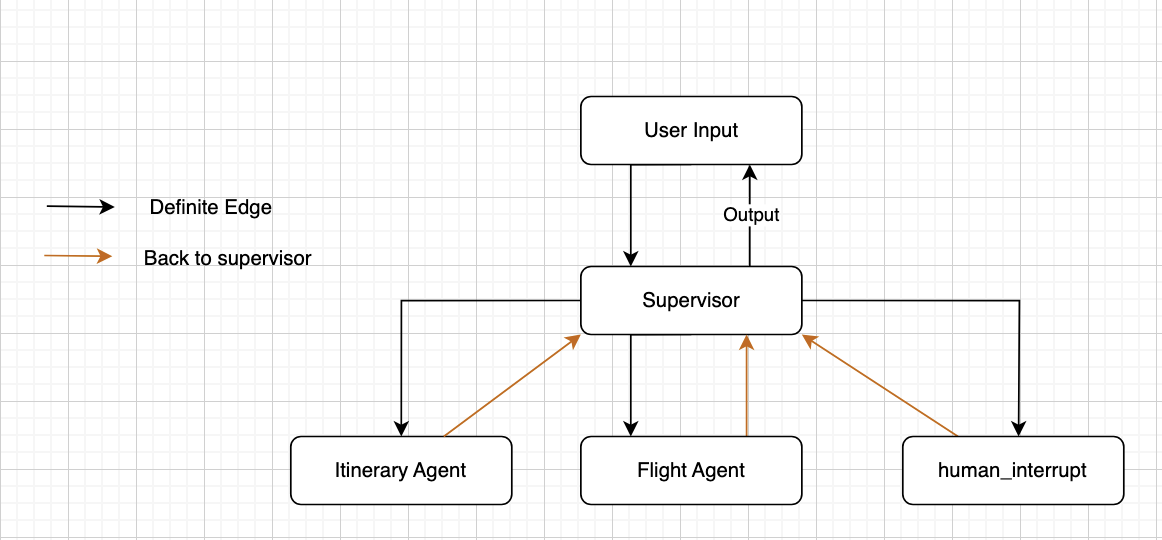

In [1]:
from IPython.display import Image
Image(filename='architecture.png')

#### State

In [1]:
from dotenv import load_dotenv
load_dotenv()

from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model_name="gpt-4o-mini")

In [2]:
from langgraph.graph import MessagesState

class State(MessagesState):
    next: str

#### Itinerary Agent

In [3]:
from typing import Annotated

itinerary_agent_prompt = """
You are an expert travel planner. Your task is to create a detailed itinerary for a trip based on the information provided by the user. The itinerary should include the following details:
- Day-by-day schedule with activities and locations
- Suggested times for each activity
- Recommendations for meals and restaurants
- Transportation options between locations
- Any special events or local attractions to consider
- Accommodation details if provided
Ensure the itinerary is well-organized, practical, and tailored to the user's preferences and constraints. Use a friendly and informative tone.
"""

def itinerary_agent(itinary_info: Annotated[str, "All the itinerary information in a plain text format"]):
    messages = [
        ("system", itinerary_agent_prompt),
        ("human", {itinary_info})
    ]

    return llm.invoke(messages)

#### Flight Agent

- This is a ReAct-style agent (Reason + Act), meaning it can decide whether it needs to use a tool to answer the user’s query about flights.
- We set up a tool for this agent to use, which can extract relevant information from user query and structure it in a way that we can use an external API (SerpAPI) to retrieve real-time flight information. 
- This process involves creating a system prompt explaining what all parameters to extract to give to the API; setting up a class which inherits TypingDict to use for LLM structured outputs to make sure we get consistent JSON outputs of these parameters; initializing the LLM with this structured output; and creating a function that invokes this LLM, extracts the parameters and calls the flight API. We use the tool decorator on this function so we can use it as a ReAct agent.

In [4]:
from typing import Annotated, Literal, Optional
from typing_extensions import TypedDict
# from serpapi import GoogleSearch
from langchain.prompts import ChatPromptTemplate
from langchain_core.tools import tool

flight_agent_prompt = """
You are an expert at extracting information out of plain text. The response should be in JSON format.
You need to extract the following parameters:
- departure_id - city/airport IATA code from which the traveler will depart, e.g. BOS for Boston
- arrival_id - city/airport IATA code from which the traveler is going, e.g. BOS for Boston
- outbound_date - the date on which the traveler will depart from the origin to go to the destination. Dates are specified in the ISO 8601 YYYY-MM-DD format, e.g. 2017-12-25
- return_date - the date on which the traveller will return from the destination back to the origin. Date is specified in the ISO 8601 YYYY-MM-DD format
"""

class Flight_parameters(TypedDict):
    departure_id: Annotated[str, ..., "city/airport IATA code from which the traveler will depart, e.g. BOS for Boston"]
    arrival_id: Annotated[str, ..., "city/airport IATA code from which the traveler is going, e.g. BOS for Boston"]
    outbound_date: Annotated[str, ..., "the date on which the traveler will depart from the origin to go to the destination. Dates are specified in the ISO 8601 YYYY-MM-DD format, e.g. 2017-12-25"]
    return_date: Annotated[Optional[str], None, "the date on which the traveller will return from the destination back to the origin. Date is specified in the ISO 8601 YYYY-MM-DD format"]

flight_prompt = ChatPromptTemplate.from_messages([('system', flight_agent_prompt), ('human', '{input}')])
structured_llm_flight = flight_prompt | llm.with_structured_output(Flight_parameters)

@tool
def flight_tool(parameters: Annotated[str,"All the flight parameters in a plain text format"]):
    """
    Get the list of available flights based on users' requirements.
    Parameters:
        query (str): User's flight requirements as natural language input.
    Returns:
        str: A human-readable response with flight offers or an error message.
    """
    flight_parameters = structured_llm_flight.invoke({'input': parameters})
    flight_parameters['engine'] = 'google_flights'
    flight_parameters['currencyCode'] = 'USD'
    flight_parameters['hl'] = 'en'
    flight_parameters['api_key'] = 'e73ab28acbc87aafcce34b21cd35b6ae948da07ea30b66a807d61fc5cfe481eb'

    search = serpapi.search(flight_parameters)
    results = search.get_dict()
    return json.dumps(results)


In [5]:
from langgraph.prebuilt import create_react_agent

flight_agent = create_react_agent(
    llm,
    tools=[flight_tool],
    prompt="""
        You are a flight agent. You are responsible for finding the best flights for the user. Analyze the user's requirements and the tool response and return a few of the best flight information.
    """
)

#### Creating the Supervising Chatbot

- This is our brain of the multi-agent system. It not only is the interaction point of our user, but also decides whether to route the conversation to itinerary_agent, flight_agent, human user or to “finish” the conversation

In [6]:
from langgraph.graph import END
from langgraph.types import Command
from typing_extensions import TypedDict
from typing import Literal

chatbot_prompt = """
You are a dedicated travel planning chatbot designed to create personalized and well-organized trip itineraries based on user preferences and constraints.
Your Responsibilities:
1. Greeting & Introduction: Start by greeting the user and explaining that you're here to help plan their trip. Inform them what task you can help them with.
    Currently you can help them with 1. flight information and 2. itinerary planning
2. Gather Preferences & Constraints: Ask the user about their travel preferences, such as destinations, budget, duration, interests (e.g., adventure, relaxation, culture), and any constraints (e.g., dietary restrictions, mobility issues).
3. Information Collection: Inquire about specific details that is required for each agent as follows - 
    - flight_agent: Departure and arrival city/airport IATA code, departure and return date.
    - itinerary_agent: preferred activities, types of accommodations, transportation preferences, and meal preferences.
    If any information is missing, ask the user for the missing information. Only move on to routing once the user has provided all the information.
4. Agent Routing: Based on the collected information, determine which agent to route the user to:
    - itinerary_agent: If sufficient trip-related information is provided or if the user asks you to come up with the rest of the information.
    - flight_agent: If the user asks for flight information.
    - human_interrupt: This is the user itself and not an expert agent. Only give response that are crafted by you or any request for additional information.
5. Response Handling:
    - Structured Output: Ensure all responses are in JSON format with the keys:
        - `next`: The next agent to route to (`itinerary_agent`, `human_interrupt`, or `FINISH`).
        - `messages`: Any messages to send to the user.
    - Information Validation: If any required information is missing or incomplete, gather more information from the user.
6. Finalization: Once the itinerary is complete, ask the user if they would like to add anything else. If not, respond with `"FINISH"` in the next key to conclude the interaction. NEVER END THE CONVERSATION WITH THE USER BEFORE THEY EXPLICITLY SAY TO END THE CONVERSATION. 
Communication Style:
- Use a friendly, clear, and informative tone.
- Ensure all questions are concise and easy to understand.
- Make the user feel supported and assured throughout the planning process.
- When you are done with the itinerary, always route to human_interrupt agent. 
Example Workflow:
1. Chatbot: "Hello! I'm here to help you plan your perfect trip. Could you please share your preferred destinations and travel dates?"
2. User: [Provides information]
3. Chatbot: [Routes to `itinerary_agent` with collected information]
4. itinerary_agent: [Creates itinerary]
5. Chatbot: "Here's your personalized itinerary! Here is the itinerary. Would you like to add anything else?"
6. User: "No, that's all. Thank you!"
7. Chatbot: `"FINISH"`
Ensure seamless and natural interactions while effectively gathering all necessary information to create a comprehensive trip itinerary.
"""

class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal['itinerary_agent', 'human_interrupt', 'FINISH']
    messages: str

def chatbot_node(state: State) -> Command[Literal['itinerary_agent', 'human_interrupt', 'flight_agent', "__end__"]]:
    messages = [
        {"role": "system", "content": chatbot_prompt},
    ] + state["messages"]

    response = llm.with_structured_output(Router).invoke(messages)

    goto = response["next"]
    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"next": goto, "messages": response["messages"]})

In [7]:
## Creating the Agent nodes
from langgraph.types import Command
from langchain_core.prompts.chat import HumanMessage
from typing_extensions import Literal

def itinerary_node(state: State) -> Command[Literal['chatbot']]:
    # Convert the state messages to a list of strings
    human_messages = [msg.content for msg in state['messages'] if isinstance(msg, HumanMessage)]

    messages = [
        ("system", itinerary_agent_prompt),
        ("human", " ".join(human_messages))
    ]

    response = llm.invoke(messages)

    return Command(goto='chatbot', update={"messages": [response.content]})

def flight_node(state: State) -> Command[Literal['chatbot']]:
    result = flight_agent.invoke(state)
    return Command(
        update={
            "messages": [result["messages"][-1].content]
        },
        goto="chatbot",
    )

In [8]:
## Setting up Human Input
from typing import Literal

def human_interrupt(state: State) -> Command[Literal['chatbot']]:

    query = state['messages'][-1].content
    user_input = input("user: ")
    return Command(goto='chatbot', update={"messages": [user_input]})

In [9]:
## Building the StateGraph

from langgraph.graph import StateGraph, START

if __name__ == "__main__":
    builder = StateGraph(State)
    builder.add_edge(START, "chatbot")
    builder.add_node("chatbot", chatbot_node)
    builder.add_node("itinerary_agent", itinerary_node)
    builder.add_node("flight_agent", flight_node)
    builder.add_node("human_interrupt", human_interrupt)
    
    graph = builder.compile()

In [10]:
for s in graph.stream({"messages": [("user", "Hi")]}, subgraphs=True):
    for key, value in s[1].items():
        if key in ['chatbot', 'itinerary_agent', 'flight_agent']:
            print(value['messages'])
    print("----")

Hello! I'm here to help you plan your perfect trip. Could you please share your preferred destinations and travel dates?
----
----
Great! I'll help you plan your itinerary. Could you please provide me with your preferred activities, types of accommodations, transportation preferences, and meal preferences?
----
["Hello! I'm excited to help you plan your perfect trip! To create an itinerary that suits your preferences, I need a bit more information from you. Please provide the following:\n\n1. **Preferred Destinations**: Where would you like to go? Any specific cities or countries in mind?\n2. **Travel Dates**: When are you planning to travel, and how many days will your trip be?\n3. **Activities**: What types of activities do you enjoy? (e.g., sightseeing, adventure sports, cultural experiences, relaxation, food tours)\n4. **Accommodation Preferences**: Do you prefer hotels, hostels, vacation rentals, or something else? Any specific budget range?\n5. **Transportation Preferences**: Wou